In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.data import TabularDataset, Iterator
import spacy
import random

# 加载 spaCy 的英文模型
nlp = spacy.load("en_core_web_sm")


In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 加载原始数据集
data = pd.read_csv('./data/tweet_emotions.csv')

# 分割数据集
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)

# 保存分割后的训练集和测试集为 CSV 文件
train_data.to_csv('./data/train_data.csv', index=False)
test_data.to_csv('./data/test_data.csv', index=False)


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext import data
from torchtext.data import TabularDataset, Iterator, Field

# 设置随机种子以保证实验的可重复性
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# 加载英文分词器
spacy_en = spacy.load('en_core_web_sm')

# 定义分词函数
def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

# 定义字段（Field）
TEXT = Field(tokenize=tokenize_en, lower=True, include_lengths=True)
LABEL = Field(sequential=False, is_target=True)

# 加载数据集
train_data, test_data = TabularDataset.splits(
    path='./data', train='train_data.csv', test='test_data.csv', format='csv',
    fields=[('tweet_id', None), ('sentiment', LABEL), ('content', TEXT)]
)

# 构建词汇表
TEXT.build_vocab(train_data, max_size=10000, vectors="glove.6B.100d")
LABEL.build_vocab(train_data)


# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 定义迭代器
BATCH_SIZE = 64
train_iterator, test_iterator = Iterator.splits(
    (train_data, test_data),
    sort_key=lambda x: len(x.content),
    sort_within_batch=True,
    batch_size=BATCH_SIZE,
    device=device
)

# 定义RNN模型
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'), enforce_sorted=False)
        packed_output, hidden = self.rnn(packed_embedded)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        return self.fc(hidden.squeeze(0))

# 初始化模型
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 训练模型
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for batch in iterator:
        optimizer.zero_grad()
        text, text_lengths = batch.content
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, batch.sentiment.float())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

# 测试模型
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.content
            predictions = model(text, text_lengths).squeeze(1)
            loss = criterion(predictions, batch.sentiment.float())
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

# 训练并测试模型
N_EPOCHS = 50
for epoch in range(N_EPOCHS):
    train_loss = train(model, train_iterator, optimizer, criterion)
    test_loss = evaluate(model, test_iterator, criterion)
    print(f'Epoch: {epoch+1}')
    print(f'\tTrain Loss: {train_loss:.3f} | Test Loss: {test_loss:.3f}')


Epoch: 1
	Train Loss: 7.419 | Test Loss: 7.334
Epoch: 2
	Train Loss: 7.174 | Test Loss: 7.255
Epoch: 3
	Train Loss: 7.188 | Test Loss: 7.276
Epoch: 4
	Train Loss: 7.058 | Test Loss: 7.340
Epoch: 5
	Train Loss: 6.923 | Test Loss: 7.510
Epoch: 6
	Train Loss: 6.763 | Test Loss: 7.605
Epoch: 7
	Train Loss: 6.554 | Test Loss: 7.592
Epoch: 8
	Train Loss: 6.308 | Test Loss: 7.844
Epoch: 9
	Train Loss: 6.019 | Test Loss: 8.227
Epoch: 10
	Train Loss: 5.695 | Test Loss: 8.368
Epoch: 11
	Train Loss: 5.301 | Test Loss: 8.386
Epoch: 12
	Train Loss: 4.881 | Test Loss: 9.065
Epoch: 13
	Train Loss: 4.424 | Test Loss: 9.154
Epoch: 14
	Train Loss: 4.003 | Test Loss: 9.513
Epoch: 15
	Train Loss: 3.541 | Test Loss: 9.552
Epoch: 16
	Train Loss: 3.138 | Test Loss: 10.342
Epoch: 17
	Train Loss: 2.778 | Test Loss: 10.510
Epoch: 18
	Train Loss: 2.567 | Test Loss: 10.547
Epoch: 19
	Train Loss: 2.257 | Test Loss: 11.015
Epoch: 20
	Train Loss: 2.003 | Test Loss: 11.026
Epoch: 21
	Train Loss: 1.834 | Test Loss: 11

In [22]:
# 保存模型
torch.save(model.state_dict(), 'simple_rnn_model.pth')
print("Model saved.")



Model saved.


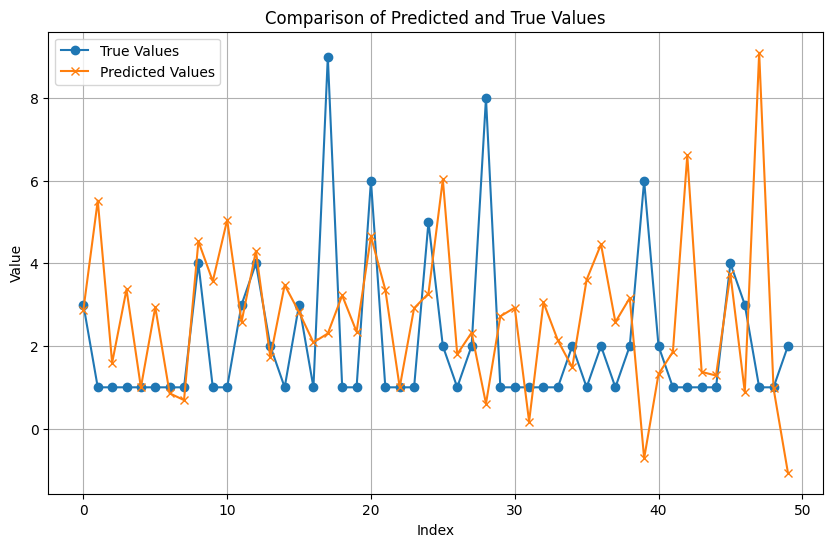

In [25]:
import matplotlib.pyplot as plt

# 加载保存的模型
model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)
model.load_state_dict(torch.load('simple_rnn_model.pth'))

# 用测试集进行预测
def predict(model, iterator):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.content
            preds = model(text, text_lengths).squeeze(1)
            predictions.extend(preds.tolist())
            actuals.extend(batch.sentiment.tolist())
    return predictions, actuals

# 进行预测
predicted_values, true_values = predict(model, test_iterator)

# 可视化预测值和真实值
plt.figure(figsize=(10, 6))
plt.plot(true_values[:50], label='True Values', marker='o')
plt.plot(predicted_values[:50], label='Predicted Values', marker='x')
plt.title('Comparison of Predicted and True Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

